# TimeEval result analysis on the correlation anomaly datasets

In [1]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "correlation-anomalies"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-12-06_runtime-correlation"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-12-03_runtime-gutentag-2-merged'),
 PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-12-02_runtime-benchmark-2-merged'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-12-02_deepant-benchmark'),
 PosixPath('/home/projects/akita/results/2021-11-01_runtime-gutentag-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),


Selecting:
Data path: /home/projects/akita/data/correlation-anomalies
Result path: /home/projects/akita/results/2021-12-06_runtime-correlation


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# add dataset_name column
df["dataset_name"] = df["dataset"].str.split(".").str[0]

# aggregate runtime
df["overall_time"] = df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0)

# remove all duplicates (not necessary, but sometimes, we have some)
df = df.drop_duplicates()

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-12-06_runtime-correlation


Define utility functions

In [4]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [5]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_name, use_plotly: bool = default_use_plotly, **kwargs):
    if not isinstance(algorithm_name, list):
        algorithms = [algorithm_name]
    else:
        algorithms = algorithm_name
    # construct dataset ID
    dataset_id = ("GutenTAG", f"{dataset_name}.unsupervised")

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[df["dataset_name"] == dataset_name, "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo in algorithms:
        algos.append(algo)
        # get algorithm metric results
        try:
            auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["dataset_name"] == dataset_name), "ROC_AUC"].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_name}.")
            auroc[algo] = -1
            skip_algos.append(algo)
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[algo] = load_scores_df(algo, ("GutenTAG", f"{dataset_name}.{training_type}")).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name}.")
            df_scores[algo] = np.nan
            skip_algos.append(algo)
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=f"channel-{i}"), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for algo in algorithms:
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[algo], name=f"{algo}={auroc[algo]:.4f}"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique(algorithms))} on {dataset_name}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=f"channel-{i}")
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for algo in algorithms:
        axs[1].plot(df_scores.index, df_scores[algo], label=f"{algo}={auroc[algo]:.4f}")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique(algorithms))} on {dataset_name}")
    fig.tight_layout()
    return fig

def plot_boxplot(df, n_show = 20, title="Box plots", ax_label="values", fmt_label=lambda x: x, use_plotly=default_use_plotly):
    n_show = n_show // 2
    title = title + f" (worst {n_show} and best {n_show} algorithms)"
    
    if use_plotly:
        import plotly.offline as py
        import plotly.graph_objects as go
        import plotly.figure_factory as ff
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        fig = go.Figure()
        for i, c in enumerate(df.columns):
            fig.add_trace(go.Box(
                x=df[c],
                name=fmt_label(c),
                boxpoints=False,
                visible=None if i < n_show or i > len(df.columns)-n_show-1 else "legendonly"
            ))
        fig.update_layout(
            title={"text": title, "xanchor": "center", "x": 0.5},
            xaxis_title=ax_label,
            legend_title="Algorithms"
        )
        return py.iplot(fig)
    else:
        df_boxplot = pd.concat([df.iloc[:, :n_show], df.iloc[:, -n_show:]])
        labels = df_boxplot.columns
        labels = [fmt_label(c) for c in labels]
        values = [df_boxplot[c].dropna().values for c in df_boxplot.columns]
        fig = plt.figure()
        ax = fig.gca()
        ax.boxplot(values, sym="", vert=True, meanline=True, showmeans=True, showfliers=False, manage_ticks=True)
        ax.set_ylabel(ax_label)
        ax.set_title(title)
        ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode="anchor")
        # add vline to separate bad and good algos
        ymin, ymax = ax.get_ylim()
        ax.vlines([n_show + 0.5], ymin, ymax, colors="black", linestyles="dashed")
        fig.tight_layout()
        return fig

def plot_algorithm_bars(df, y_name="ROC_AUC", title="Bar chart for algorithms", use_plotly=default_use_plotly, color="blue", legend=True):
    if use_plotly:
        fig = px.bar(df, x="algorithm", y=y_name)
        py.iplot(fig)
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(df["algorithm"], df[y_name], label=y_name, color=color)
        ax.set_ylabel(y_name)
        ax.set_title(title)
        ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
        if legend:
            ax.legend()
        return fig

## Analyze overall results on the GutenTAG datasets

### Overview

In [76]:
df[["algorithm", "collection", "dataset_name", "status", "ROC_AUC", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "execute_main_time", "hyper_params"]]

,algorithm,collection,dataset_name,status,ROC_AUC,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,execute_main_time,hyper_params
0,CBLOF,GutenTAG,rmj-2-short-anomalies-on-2-different-channel,Status.OK,1.0,1.000,1.000,0.527960,62.570714,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
1,CBLOF,GutenTAG,rmj-2-short-anomalies-on-2-same-channel,Status.OK,1.0,1.000,1.000,0.527932,60.872355,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
2,CBLOF,GutenTAG,rmj-3-short-anomalies-on-3-different-channel,Status.OK,1.0,1.000,1.000,0.521701,63.311784,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
3,CBLOF,GutenTAG,rmj-3-short-anomalies-on-3-same-channel,Status.OK,1.0,1.000,1.000,0.521667,63.228857,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
4,CBLOF,GutenTAG,rmj-large-mode-correlation-on-2,Status.OK,1.0,1.000,1.000,0.514474,62.570419,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
...,...,...,...,...,...,...,...,...,...,...
359,normal,GutenTAG,rmj-medium-mode-correlation-on-3,Status.OK,0.5,0.008,0.504,0.504000,0.000015,{}
360,normal,GutenTAG,rmj-medium-mode-correlation-on-4,Status.OK,0.5,0.008,0.504,0.504000,0.000020,{}
361,normal,GutenTAG,rmj-short-mode-correlation-on-2,Status.OK,0.5,0.004,0.502,0.502000,0.000017,{}
362,normal,GutenTAG,rmj-short-mode-correlation-on-3,Status.OK,0.5,0.004,0.502,0.502000,0.000018,{}


### Algorithm problems grouped by algorithm training type

In [7]:
index_columns = ["algo_training_type", "algo_input_dimensionality", "algorithm"]
df_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
df_error_counts = df_error_counts.fillna(value=0).astype(np.int64)
df_error_counts = df_error_counts.reset_index().sort_values(by=["algo_input_dimensionality", "Status.ERROR"], ascending=False).set_index(index_columns)
df_error_counts["ALL"] = df_error_counts["Status.ERROR"] + df_error_counts["Status.OK"] + df_error_counts["Status.TIMEOUT"]

for tpe in ["SEMI_SUPERVISED", "SUPERVISED", "UNSUPERVISED"]:
    if tpe in df_error_counts.index:
        print(tpe)
        if default_use_plotly:
            py.iplot(ff.create_table(df_error_counts.loc[tpe], index=True))
        else:
            display(df_error_counts.loc[tpe])

SEMI_SUPERVISED


status                                              Status.ERROR  Status.OK  \
algo_input_dimensionality algorithm                                           
MULTIVARIATE              LSTM-AD                              8          0   
                          EncDec-AD                            1          7   
                          DeepAnT                              0         13   
                          HealthESN                            0          0   
                          Hybrid KNN                           0         13   
                          LaserDBN                             0         13   
                          OmniAnomaly                          0         13   
                          Random Black Forest (RR)             0         13   
                          RobustPCA                            0         13   
                          TAnoGan                              0          0   
                          Telemanom                            0         13   

status                                              Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                      
MULTIVARIATE              LSTM-AD                                5   13  
                          EncDec-AD                              5   13  
                          DeepAnT                                0   13  
                          HealthESN                             13   13  
                          Hybrid KNN                             0   13  
                          LaserDBN                               0   13  
                          OmniAnomaly                            0   13  
                          Random Black Forest (RR)               0   13  
                          RobustPCA                              0   13  
                          TAnoGan                               13   13  
                          Telemanom                              0   13

SUPERVISED


status                                                   Status.ERROR  \
algo_input_dimensionality algorithm                                     
MULTIVARIATE              MultiHMM                                 13   
                          Normalizing Flows                         3   
                          Hybrid Isolation Forest (HIF)             0   

status                                                   Status.OK  \
algo_input_dimensionality algorithm                                  
MULTIVARIATE              MultiHMM                               0   
                          Normalizing Flows                      0   
                          Hybrid Isolation Forest (HIF)         13   

status                                                   Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                           
MULTIVARIATE              MultiHMM                                    0   13  
                          Normalizing Flows                          10   13  
                          Hybrid Isolation Forest (HIF)               0   13

UNSUPERVISED


status                                                     Status.ERROR  \
algo_input_dimensionality algorithm                                       
MULTIVARIATE              DBStream                                    4   
                          CBLOF                                       0   
                          COF                                         0   
                          COPOD                                       0   
                          Extended Isolation Forest (EIF)             0   
                          HBOS                                        0   
                          IF-LOF                                      0   
                          Isolation Forest (iForest)                  0   
                          KNN                                         0   
                          LOF                                         0   
                          PCC                                         0   
                          Torsk                                       0   
                          k-Means                                     0   
                          normal                                      0   

status                                                     Status.OK  \
algo_input_dimensionality algorithm                                    
MULTIVARIATE              DBStream                                 9   
                          CBLOF                                   13   
                          COF                                     13   
                          COPOD                                   13   
                          Extended Isolation Forest (EIF)         13   
                          HBOS                                    13   
                          IF-LOF                                  13   
                          Isolation Forest (iForest)              13   
                          KNN                                     13   
                          LOF                                     13   
                          PCC                                     13   
                          Torsk                                   13   
                          k-Means                                 13   
                          normal                                  13   

status                                                     Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                             
MULTIVARIATE              DBStream                                      0   13  
                          CBLOF                                         0   13  
                          COF                                           0   13  
                          COPOD                                         0   13  
                          Extended Isolation Forest (EIF)               0   13  
                          HBOS                                          0   13  
                          IF-LOF                                        0   13  
                          Isolation Forest (iForest)                    0   13  
                          KNN                                           0   13  
                          LOF                                           0   13  
                          PCC                                           0   13  
                          Torsk                                         0   13  
                          k-Means                                       0   13  
                          normal                                        0   13

#### Very slow algorithms

Algorithms, for which more than 50% of all executions ran into the timeout. You can adjust the timeout threshold.

In [8]:
timeout_threshold = 0.5
df_error_counts[df_error_counts["Status.TIMEOUT"] > timeout_threshold*df_error_counts["ALL"]].sort_index(level=[0, 1])

status                                                          Status.ERROR  \
algo_training_type algo_input_dimensionality algorithm                         
SEMI_SUPERVISED    MULTIVARIATE              HealthESN                     0   
                                             TAnoGan                       0   
SUPERVISED         MULTIVARIATE              Normalizing Flows             3   

status                                                          Status.OK  \
algo_training_type algo_input_dimensionality algorithm                      
SEMI_SUPERVISED    MULTIVARIATE              HealthESN                  0   
                                             TAnoGan                    0   
SUPERVISED         MULTIVARIATE              Normalizing Flows          0   

status                                                          Status.TIMEOUT  \
algo_training_type algo_input_dimensionality algorithm                           
SEMI_SUPERVISED    MULTIVARIATE              HealthESN                      13   
                                             TAnoGan                        13   
SUPERVISED         MULTIVARIATE              Normalizing Flows              10   

status                                                          ALL  
algo_training_type algo_input_dimensionality algorithm               
SEMI_SUPERVISED    MULTIVARIATE              HealthESN           13  
                                             TAnoGan             13  
SUPERVISED         MULTIVARIATE              Normalizing Flows   13

#### Broken algorithms

Algorithms, which failed for at least 50% of the executions. You can adjust the error threshold.

In [9]:
error_threshold = 0.5
df_error_counts[df_error_counts["Status.ERROR"] > error_threshold*df_error_counts["ALL"]].sort_index(level=[0, 1])

,,status,Status.ERROR,Status.OK,Status.TIMEOUT,ALL
algo_training_type,algo_input_dimensionality,algorithm,,,,
SEMI_SUPERVISED,MULTIVARIATE,LSTM-AD,8,0,5,13
SUPERVISED,MULTIVARIATE,MultiHMM,13,0,0,13


Inspect errors of a specific algorithm:

In [10]:
from collections import defaultdict

algo = "Normalizing Flows"

executions = [f for f in (result_path / algo).glob("**/execution.log") if not (f.parent / "anomaly_scores.ts").is_file()]
errors = defaultdict(int)
for x in executions:
    with x.open() as fh:
        log = fh.read()
    if "TimeoutError" in log:
        errors["TimeoutError"] += 1
    elif "NameError: name 'nan' is not defined" in log:
        errors["Could not load model, bc. empty distribution fit."] += 1
    elif "ValueError: Expected 2D array, got 1D array instead" in log:
        errors["Wrong shape error"] += 1
    elif "status code '139'" in log:
        errors["Segfault"] += 1
    elif "status code '137'" in log:
        errors["OOM"] += 1
    else:
        print("---------------------------------------------------------------------------------")
        print(log)

print("\nSummary")
for err_tpe in errors:
    print(f"  {errors[err_tpe]} {err_tpe}")


Summary
  10 TimeoutError
  3 OOM


### Remove some duplicated entries

Some algorithms were run multiple times per dataset, because we made a mistake with the parameter configuration for the first run. For example consider these two runs of Bagel:

In [11]:
df_bagel_duplicates = df[(df["algorithm"] == "Bagel") & (df["dataset_name"] == "sinus-type-mean")][["algorithm", "dataset_name", "hyper_params_id", "hyper_params", "status"]]
display(df_bagel_duplicates)
print("Full parameter lists:")
params = df_bagel_duplicates["hyper_params"].to_list()
for param_set in params:
    print(f"  {param_set}")

,algorithm,dataset_name,hyper_params_id,hyper_params,status


Full parameter lists:


We want to consider only the best run for each `algorithm`-`dataset_name`-combination (over all `hyper_params` and `repetition`s) for the analysis in this notebook. Therefore, we filter out the other runs:

In [12]:
def filter_groups(group):
    if len(group) > 1:
        group = group.sort_values(by="ROC_AUC", ascending=False)
    return group[:1]

df_grouped = df.groupby(by=["algorithm", "collection", "dataset_name"])
df_grouped = df_grouped.apply(filter_groups)
df = df_grouped.reset_index(drop=True)
df = df.sort_values(by=["algorithm", "dataset_name"])

### Algorithm quality assessment based on ROC_AUC

In [13]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_scores = df.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_overall_scores.columns = aggregations
df_overall_scores = df_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_asl = df.pivot(index="algorithm", columns="dataset_name", values="ROC_AUC")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl[dominant_aggregation] = df_asl.agg(dominant_aggregation, axis=1)
df_asl = df_asl.sort_values(by=dominant_aggregation, ascending=True)
df_asl = df_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_scores.T)

algorithm,CBLOF,Extended Isolation Forest (EIF),Isolation Forest (iForest),LaserDBN,KNN,k-Means,DBStream,Hybrid Isolation Forest (HIF),Telemanom,OmniAnomaly,Random Black Forest (RR),DeepAnT,EncDec-AD,LOF,IF-LOF,COF,Torsk,RobustPCA,COPOD,HBOS,normal,PCC,Hybrid KNN
min,1.0,1.0,0.999752,0.999595,0.999136,0.997290,0.994167,0.979751,0.841556,0.143524,0.017327,0.208494,0.514534,0.301583,0.297556,0.421224,0.330691,0.000000,0.432874,0.461822,0.5,0.000000,0.000008
mean,1.0,1.0,0.999968,0.999837,0.999747,0.999456,0.998046,0.987663,0.983331,0.905308,0.839587,0.820110,0.805430,0.730557,0.728854,0.696245,0.672285,0.573686,0.536882,0.505114,0.5,0.298905,0.036683
median,1.0,1.0,1.000000,0.999849,1.000000,0.999839,0.998813,0.988819,0.997806,0.980893,0.988353,0.867569,0.817637,0.988320,0.988518,0.789019,0.684561,0.566566,0.524291,0.506042,0.5,0.422476,0.003676
max,1.0,1.0,1.000000,0.999949,1.000000,1.000000,1.000000,0.991999,0.999997,0.990750,0.989677,0.999997,1.000000,1.000000,1.000000,0.895620,0.979777,1.000000,0.617983,0.555459,0.5,0.577325,0.163215


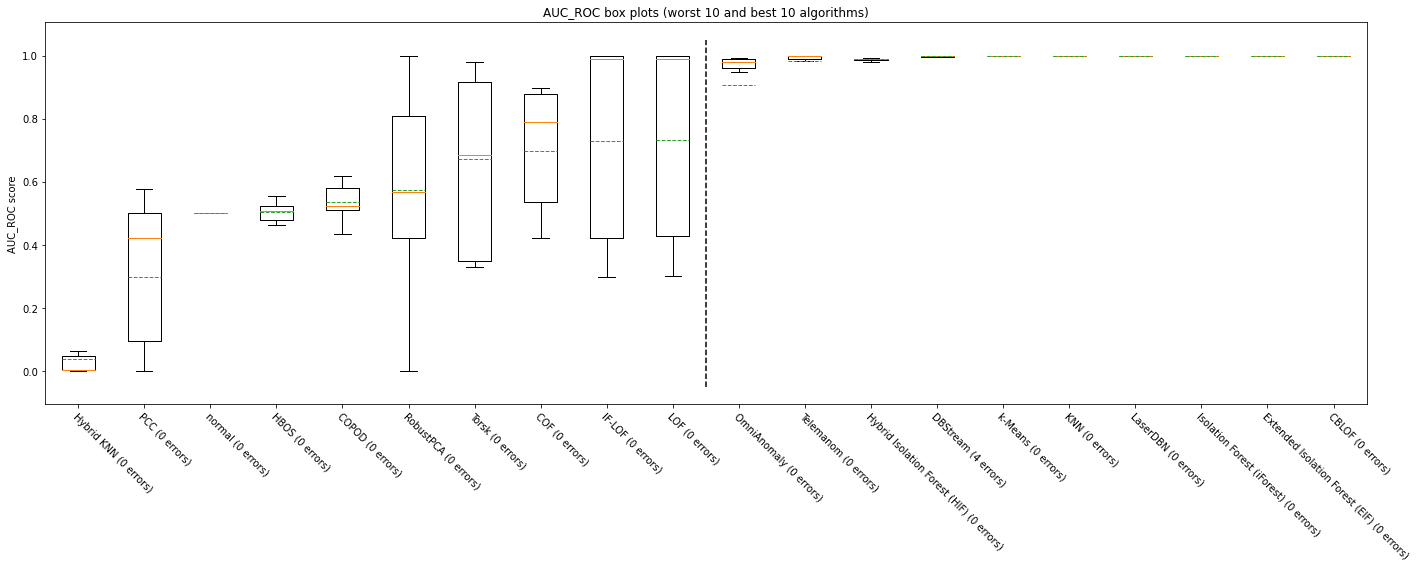

In [17]:
n_show = 20
error_count_lut = (df_error_counts["Status.ERROR"] + df_error_counts["Status.TIMEOUT"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({error_count_lut[c]} errors)"

fig = plot_boxplot(df_asl, title="AUC_ROC box plots", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)

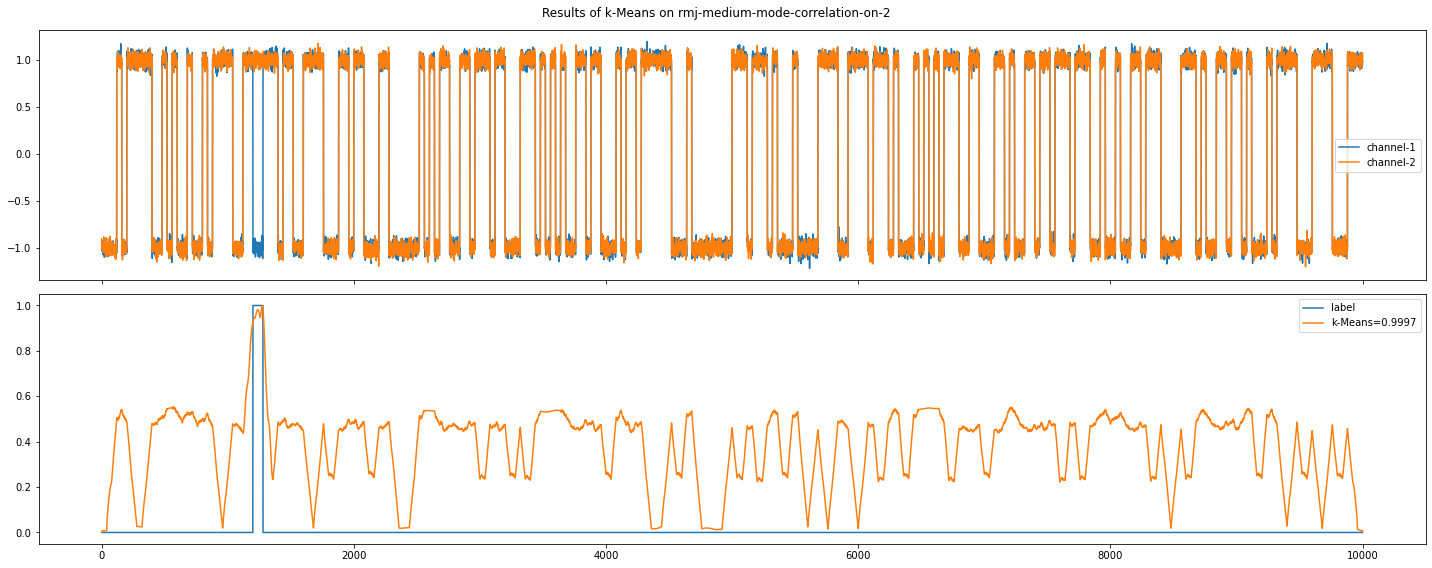

In [73]:
fig = plot_scores("k-Means", "rmj-medium-mode-correlation-on-2")

#### Best algorithms (based on mean ROC_AUC)

In [18]:
df_overall_scores.head()

,min,mean,median,max
algorithm,,,,
CBLOF,1.000000,1.000000,1.000000,1.000000
Extended Isolation Forest (EIF),1.000000,1.000000,1.000000,1.000000
Isolation Forest (iForest),0.999752,0.999968,1.000000,1.000000
LaserDBN,0.999595,0.999837,0.999849,0.999949
KNN,0.999136,0.999747,1.000000,1.000000


#### Worst algorithms (based on mean ROC_AUC)

In [19]:
df_overall_scores.tail()

,min,mean,median,max
algorithm,,,,
COPOD,0.432874,0.536882,0.524291,0.617983
HBOS,0.461822,0.505114,0.506042,0.555459
normal,0.500000,0.500000,0.500000,0.500000
PCC,0.000000,0.298905,0.422476,0.577325
Hybrid KNN,0.000008,0.036683,0.003676,0.163215


#### Scores of best algorithms

Please select a dataset (and algorithm if needed):

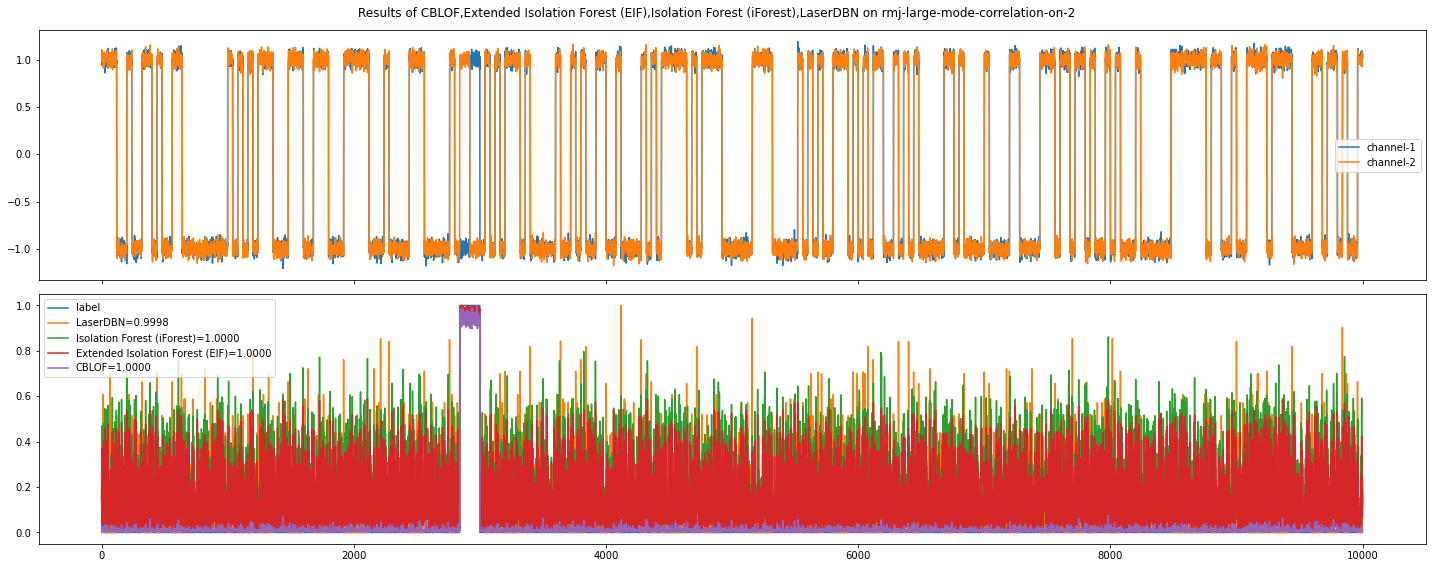

In [22]:
dataset_name = "rmj-large-mode-correlation-on-2"
algorithm_name = None
n_algos = 4

fig = plot_scores(algorithm_name if algorithm_name else df_asl.columns[-n_algos:].to_list(), dataset_name)

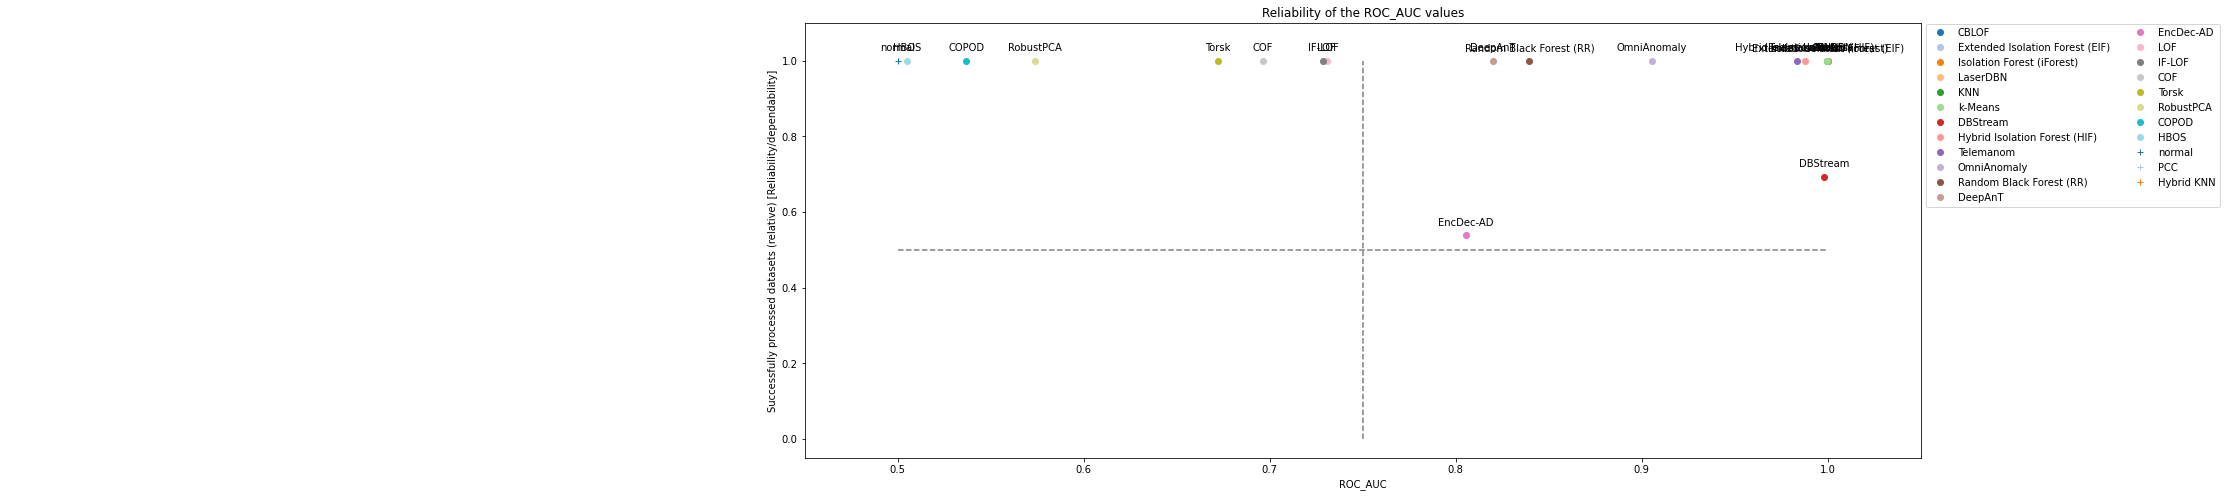

In [23]:
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
algo_auroc = df_overall_scores["mean"]
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

fig = plt.figure()
ax = fig.gca()
ax.set_prop_cycle(cycler)
for c in df_overall_scores.index:
    x = algo_auroc[c]
    y = dataset_count_lut[c]
    ax.plot(x, y, label=c, linestyle="")
    ax.annotate(c, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")

# add vline to separate bad and good algos
ax.vlines([0.75], 0, 1, colors="grey", linestyles="dashed")
ax.hlines([0.5], 0.5, 1, colors="grey", linestyles="dashed")
ax.set_xlabel("ROC_AUC")
ax.set_ylabel("Successfully processed datasets (relative) [Reliability/dependability]")
ax.set_title("Reliability of the ROC_AUC values")
ax.set_xlim(0.45, 1.05)
ax.set_ylim(-0.05, 1.1)
ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.show()

### Runtime-weighted AUC_ROC scores

/tmp/ipykernel_12358/994922933.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


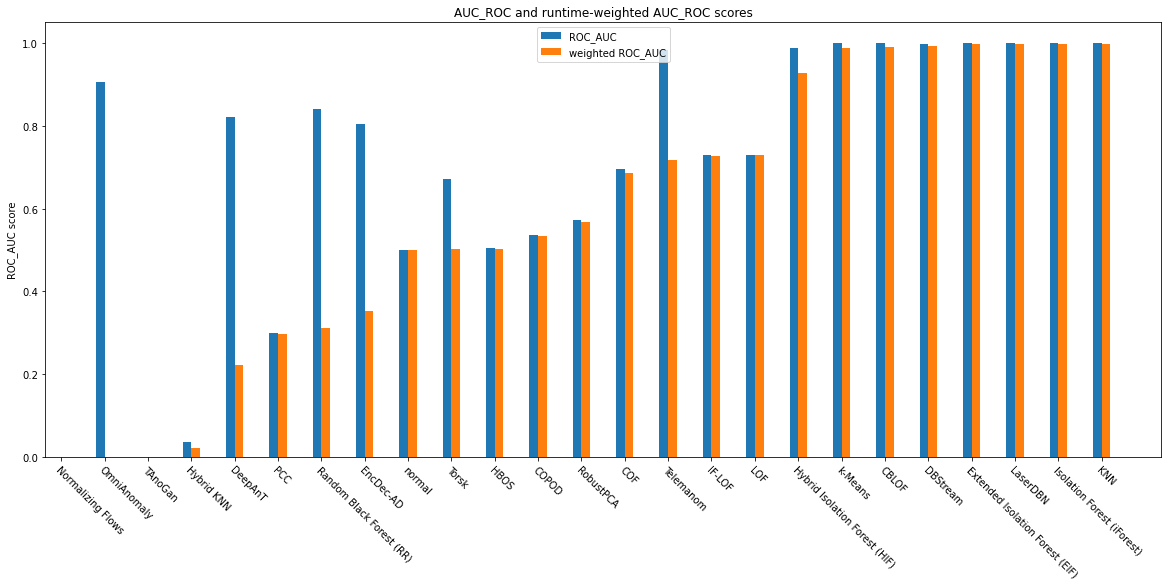

In [24]:
df_tmp = df.pivot_table(index="algorithm", values=["ROC_AUC", "overall_time"], aggfunc="mean")

from sklearn.preprocessing import MinMaxScaler
df_tmp["overall_time"] = 1 - MinMaxScaler(feature_range=(1e-6, 1)).fit_transform(df_tmp["overall_time"].values.reshape(-1, 1)).reshape(-1)
df_tmp = df_tmp.replace(0, np.nan)
df_tmp["weighted ROC_AUC"] = df_tmp["ROC_AUC"] * df_tmp["overall_time"]

df_tmp = df_tmp.sort_values(by="weighted ROC_AUC", ascending=True, na_position="first")
df_tmp.reset_index(drop=False, inplace=True)

if default_use_plotly:
    fig = px.bar(df_tmp, x="algorithm", y=["ROC_AUC", "weighted ROC_AUC"], hover_data=["overall_time"], barmode="group")
    py.iplot(fig)
else:
    fig = plt.figure()
    ax = fig.gca()
    ax.bar(df_tmp["algorithm"], df_tmp["ROC_AUC"], label="ROC_AUC", width=-0.2, align="edge")
    ax.bar(df_tmp["algorithm"], df_tmp["weighted ROC_AUC"], label="weighted ROC_AUC", width=0.2, align="edge")
    ax.set_ylabel("ROC_AUC score")
    ax.set_title(f"AUC_ROC and runtime-weighted AUC_ROC scores")
    ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
    ax.legend()
    fig.show()

### Algorithm runtime assessment

In [25]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_runtime = df.pivot_table(index="algorithm", values="overall_time", aggfunc=aggregations)
df_overall_runtime.columns = aggregations
df_overall_runtime = df_overall_runtime.sort_values(by=dominant_aggregation, ascending=True)


df_arl = df.pivot(index="algorithm", columns="dataset_name", values="overall_time")
df_arl = df_arl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_arl[dominant_aggregation] = df_arl.agg(dominant_aggregation, axis=1)
df_arl = df_arl.sort_values(by=dominant_aggregation, ascending=True)
df_arl = df_arl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_runtime.T)

algorithm,TAnoGan,Normalizing Flows,MultiHMM,LSTM-AD,HealthESN,normal,KNN,PCC,LOF,Isolation Forest (iForest),IF-LOF,LaserDBN,Extended Isolation Forest (EIF),HBOS,COPOD,DBStream,CBLOF,RobustPCA,k-Means,COF,Hybrid Isolation Forest (HIF),Torsk,Telemanom,Hybrid KNN,EncDec-AD,Random Black Forest (RR),DeepAnT,OmniAnomaly
min,0.0,0.0,0.0,0.0,0.0,0.000015,6.464279,5.712378,6.821153,9.044202,7.767577,9.060624,15.825579,23.189873,34.316063,0.000000,58.871855,23.920468,47.243240,70.085902,327.989608,693.465072,1749.286077,1738.190183,0.000000,3039.877223,2737.887857,7278.407141
mean,0.0,0.0,0.0,0.0,0.0,0.000028,9.773454,10.878109,12.877542,14.511526,16.136594,17.034520,23.146284,38.305813,38.773752,39.523480,62.624062,63.266246,81.450886,99.888026,444.339451,1844.480257,1975.161254,2878.759126,4099.722941,4572.978252,5309.997577,7286.392378
median,0.0,0.0,0.0,0.0,0.0,0.000020,7.720574,7.935372,7.992608,11.350496,13.373185,14.727425,24.554920,35.742870,35.577961,50.419758,62.570714,68.126869,63.395881,111.266032,447.190938,1842.717935,1941.312331,2979.132942,7299.616730,4515.037865,4986.422347,7286.161518
max,0.0,0.0,0.0,0.0,0.0,0.000110,22.607579,22.696771,30.752984,28.355791,31.348478,40.751291,30.472956,55.145174,47.421301,77.663769,66.912624,89.902494,156.496439,128.001117,482.646667,3544.436136,2453.794722,5338.533999,7768.236337,6648.225121,7400.551353,7293.034371


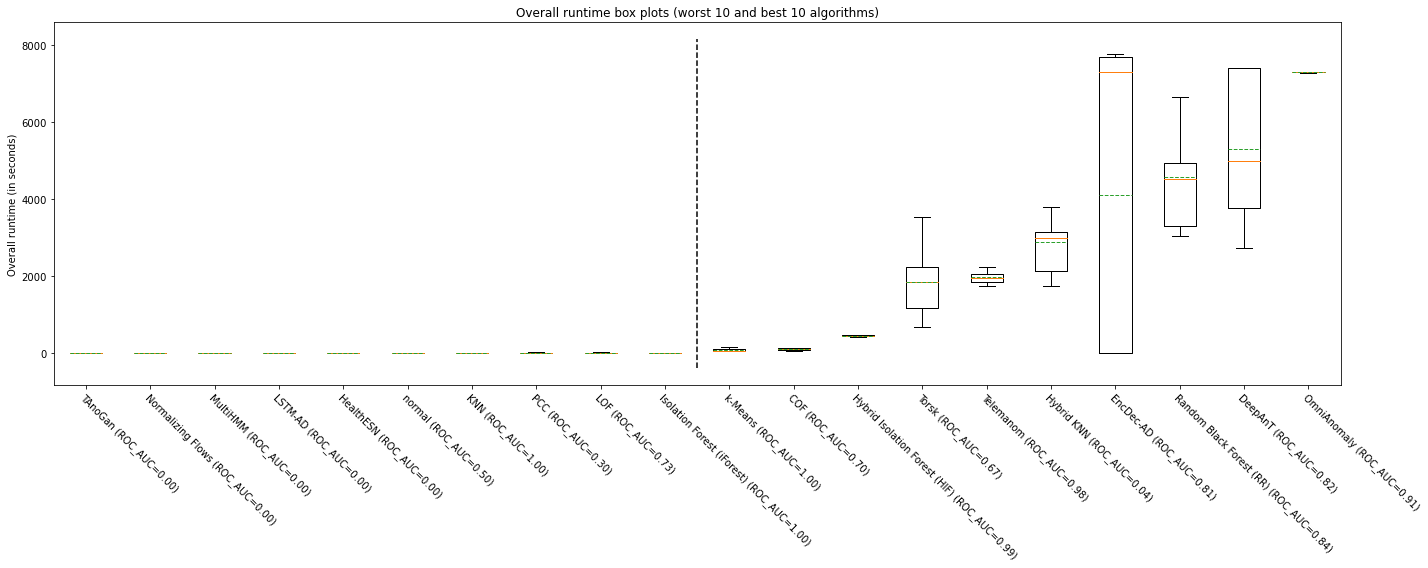

In [28]:
n_show = 20
n_show = n_show // 2
def fmt_label(c):
    try:
        score = df_overall_scores.loc[c, 'mean']
    except KeyError:
        score = 0
    return f"{c} (ROC_AUC={score:.2f})"

fig = plot_boxplot(df_arl, title="Overall runtime box plots", ax_label="Overall runtime (in seconds)", fmt_label=fmt_label)

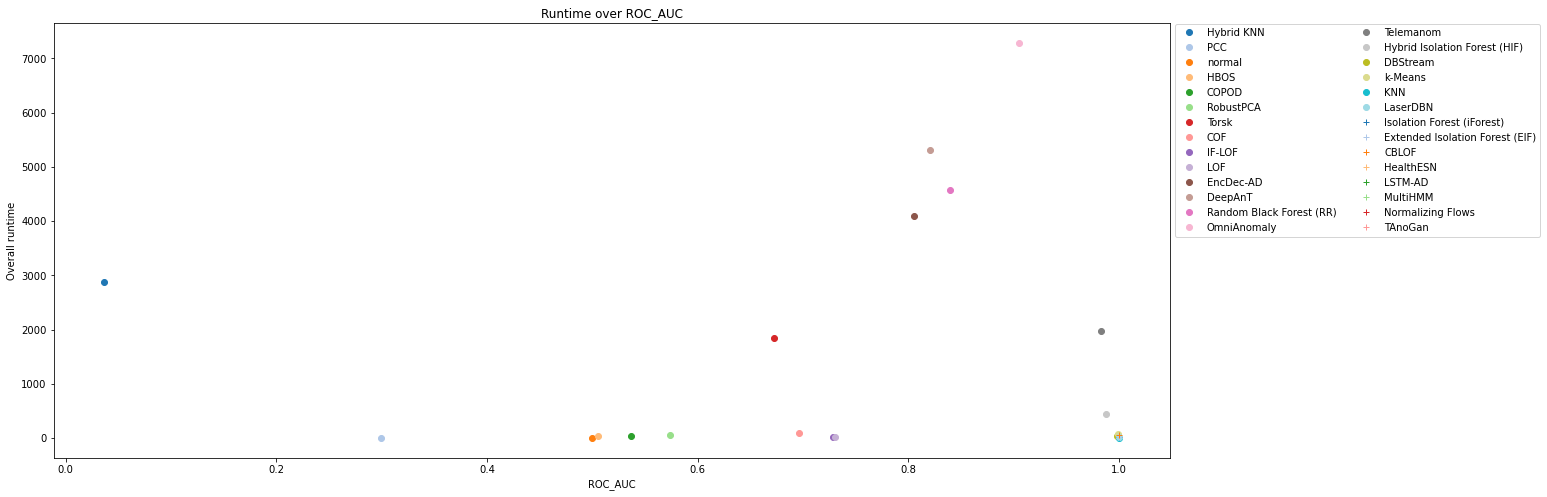

In [29]:
df_tmp = df.groupby(by="algorithm")[["ROC_AUC", "overall_time"]].mean().sort_values("ROC_AUC").T
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

fig = plt.figure()
ax = fig.gca()
ax.set_prop_cycle(cycler)
for c in df_tmp:
    x = df_tmp.loc["ROC_AUC", c]
    y = df_tmp.loc["overall_time", c]
    ax.plot(x, y, label=c, linestyle="")
    #ax.annotate(c, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")
ax.set_ylabel("Overall runtime")
ax.set_xlabel("ROC_AUC")
ax.set_title("Runtime over ROC_AUC")
ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.show()

## Detailed analysis of certain algorithm or dataset aspects

In [30]:
method_families = ["forecasting", "reconstruction", "distribution", "trees", "distance", "compression", "baseline"]
algo_metadata = [
  {"name": "AD-LTI", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "ARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Autoencoder (AE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Bagel", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "CBLOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COPOD", "research_area": "Ourlier Detection", "method_family": "distribution"},
  {"name": "DenoisingAutoEncoder (DAE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DBStream", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "DeepAnT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "DeepNAP", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Donut", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DSPOT", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "DWT-MLEAD", "research_area": "Signal Analysis", "method_family": "distribution"},
  {"name": "Extended Isolation Forest (EIF)", "research_area": "Classic Machine Learning", "method_family": "trees"},
  {"name": "EncDec-AD", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Ensemble GI", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "FFT", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "Random Forest Regressor (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "XGBoosting (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "GrammarViz", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "HBOS", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "HealthESN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Hybrid Isolation Forest (HIF)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "HOT SAX", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Hybrid KNN", "research_area": "Deep Learning", "method_family": "distance"},
  {"name": "IF-LOF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Isolation Forest (iForest)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "ImageEmbeddingCAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "k-Means", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "KNN", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "LaserDBN", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "Left STAMPi", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "LSTM-AD", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "LSTM-VAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MedianMethod", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "MSCRED", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MTAD-GAT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "MultiHMM", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "NormA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Normalizing Flows", "research_area": "Deep Learning", "method_family": "distribution"},
  {"name": "NoveltySVR", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "NumentaHTM", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OceanWNN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OmniAnomaly", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "PCC", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "PCI", "research_area": "Statistics (Regression & Forecasting)", "method_family": "reconstruction"},
  {"name": "PhaseSpace-SVM", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "PST", "research_area": "Data Mining", "method_family": "trees"},
  {"name": "Random Black Forest (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "RobustPCA", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "S-H-ESD (Twitter)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "SAND", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "SARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Series2Graph", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Spectral Residual (SR)", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "SR-CNN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "SSA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STAMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STOMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Subsequence Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "Subsequence IF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Subsequence LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "TAnoGAN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "TARZAN", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Telemanom", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Torsk", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Triple ES (Holt-Winter's)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "TSBitmap", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "VALMOD", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "normal", "research_area": "None", "method_family": "baseline"},
  {"name": "Random", "research_area": "None", "method_family": "baseline"},
  {"name": "increasing", "research_area": "None", "method_family": "baseline"},
]

algo_meta_lut = {}
for obj in algo_metadata:
    algo_meta_lut[obj["name"]] = obj
# fix some typos:
algo_meta_lut["TAnoGan"] = algo_meta_lut["TAnoGAN"]
algo_meta_lut["random"] = algo_meta_lut["Random"]

In [31]:
from matplotlib import cm

def get_color_by_family(algorithm_name):
    family = algo_meta_lut[algorithm_name]["method_family"]
    return cm.Pastel1(method_families.index(family))

### Best algorithms for number of channels

Find dataset names:

In [42]:
dataset_names = df_asl.index
def get_dataset_names_by_channels(n):
    return dataset_names[dataset_names.str.contains(f"-on-{n}")]

#### 2 Channels

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


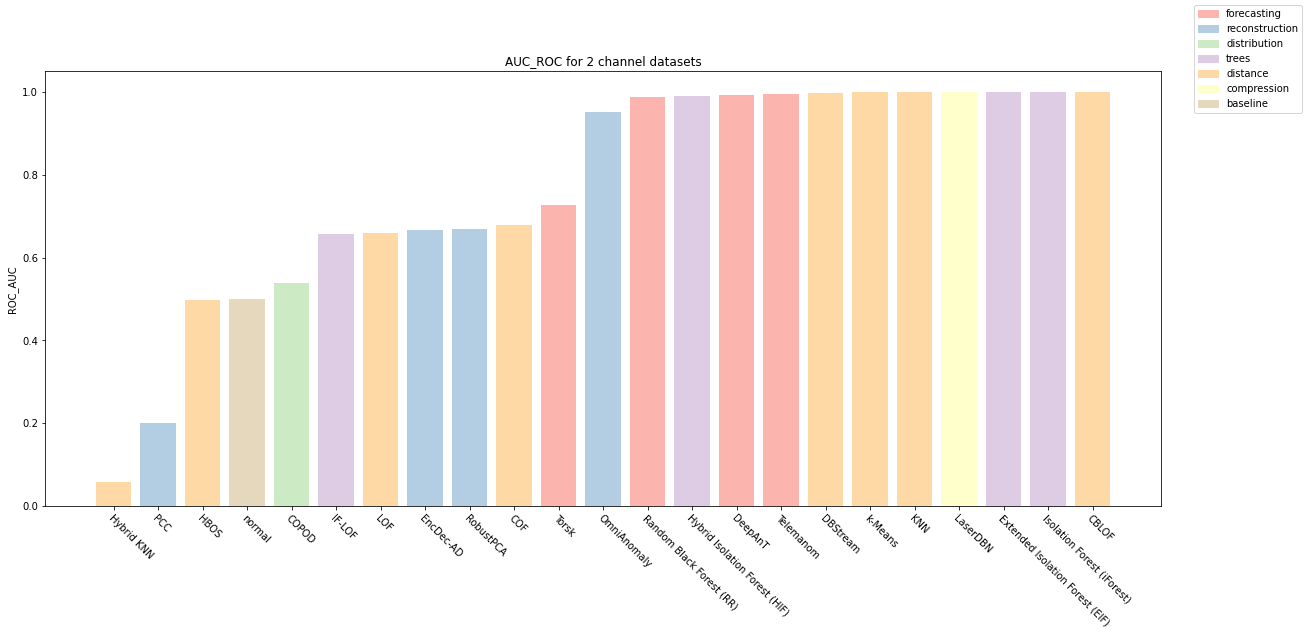

In [44]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_channels(2)].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for 2 channel datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

#### 3 Channels

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


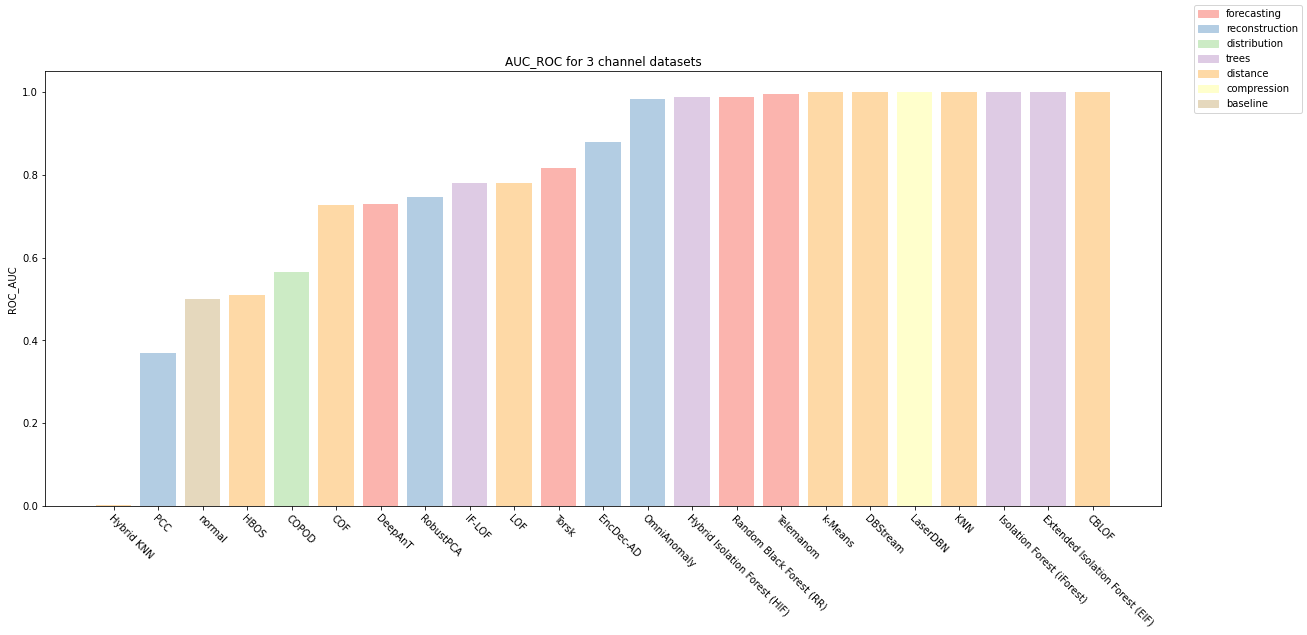

In [48]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_channels(3)].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for 3 channel datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

#### 4 Channels

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


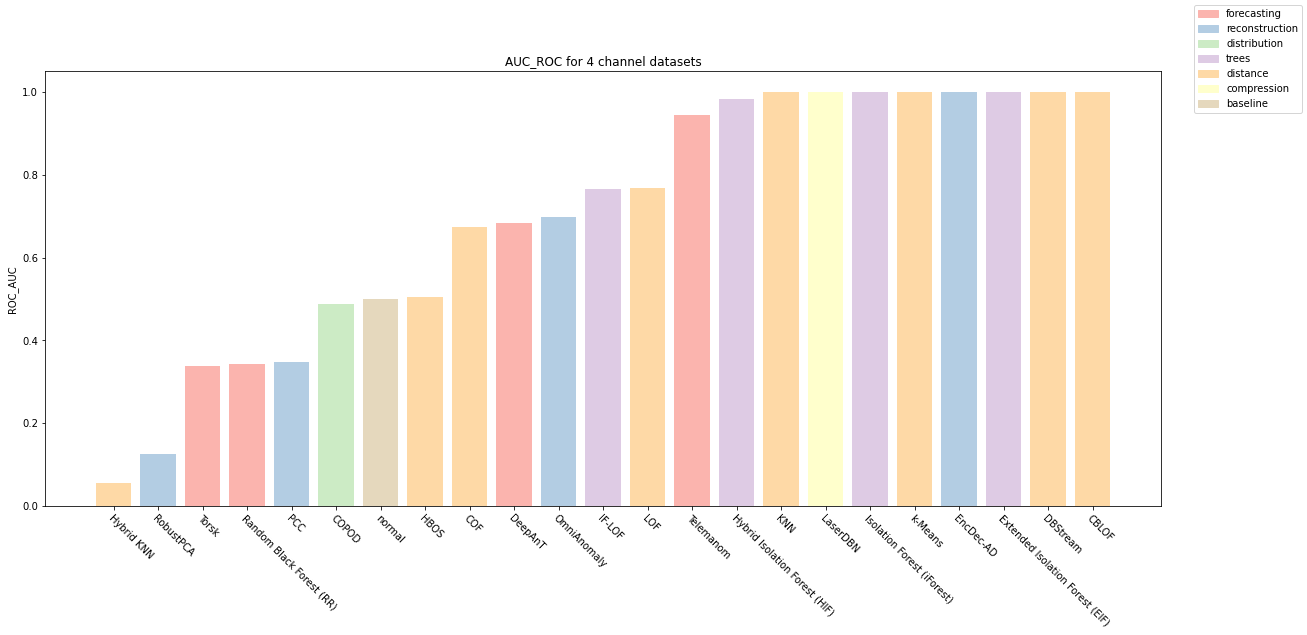

In [47]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_channels(4)].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for 4 channel datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

### Best algorithms for same and different channel correlation anomalies

Find dataset names:

In [51]:
dataset_names = df_asl.index
same_anomaly_datasets = dataset_names[dataset_names.str.contains("same-channel")]
diff_anomaly_datasets = dataset_names[dataset_names.str.contains("different-channel")]

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


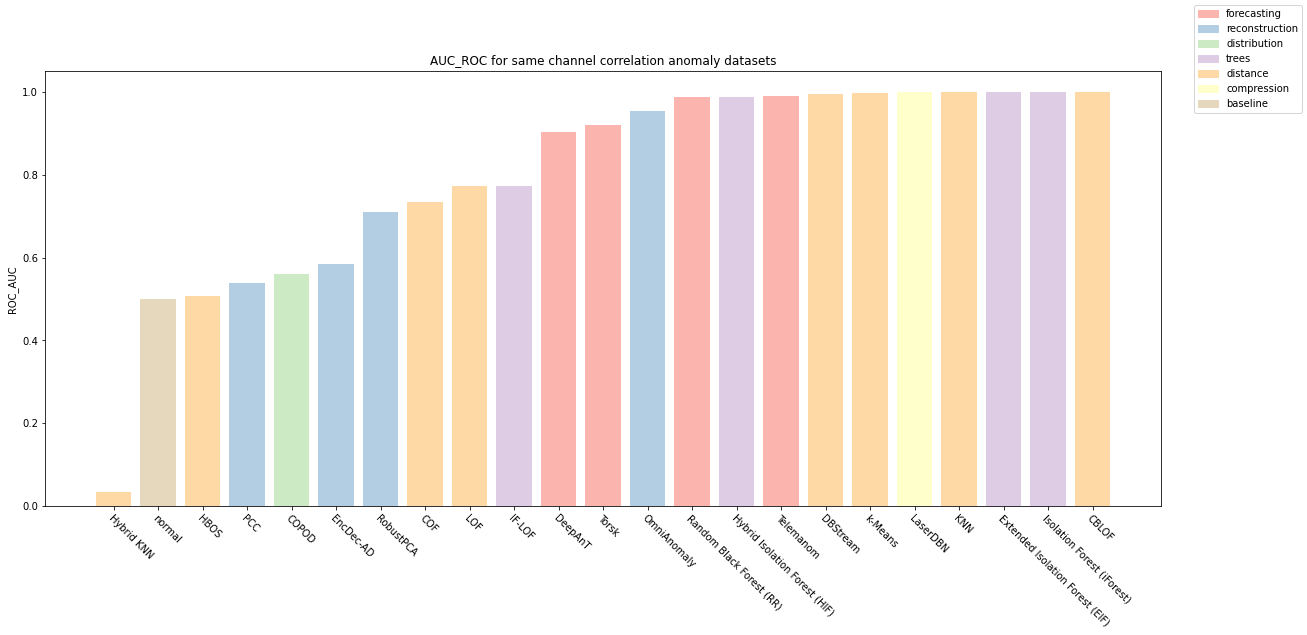

In [54]:
df_tmp = pd.DataFrame(df_asl.loc[same_anomaly_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for same channel correlation anomaly datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


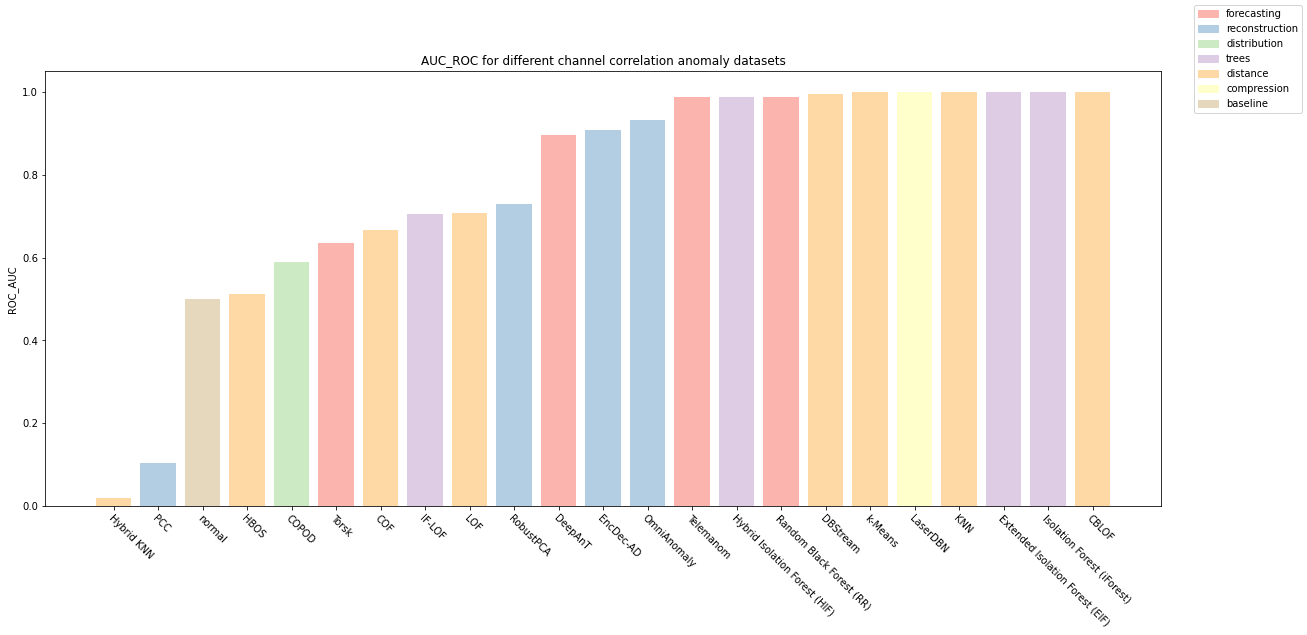

In [55]:
df_tmp = pd.DataFrame(df_asl.loc[diff_anomaly_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for different channel correlation anomaly datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

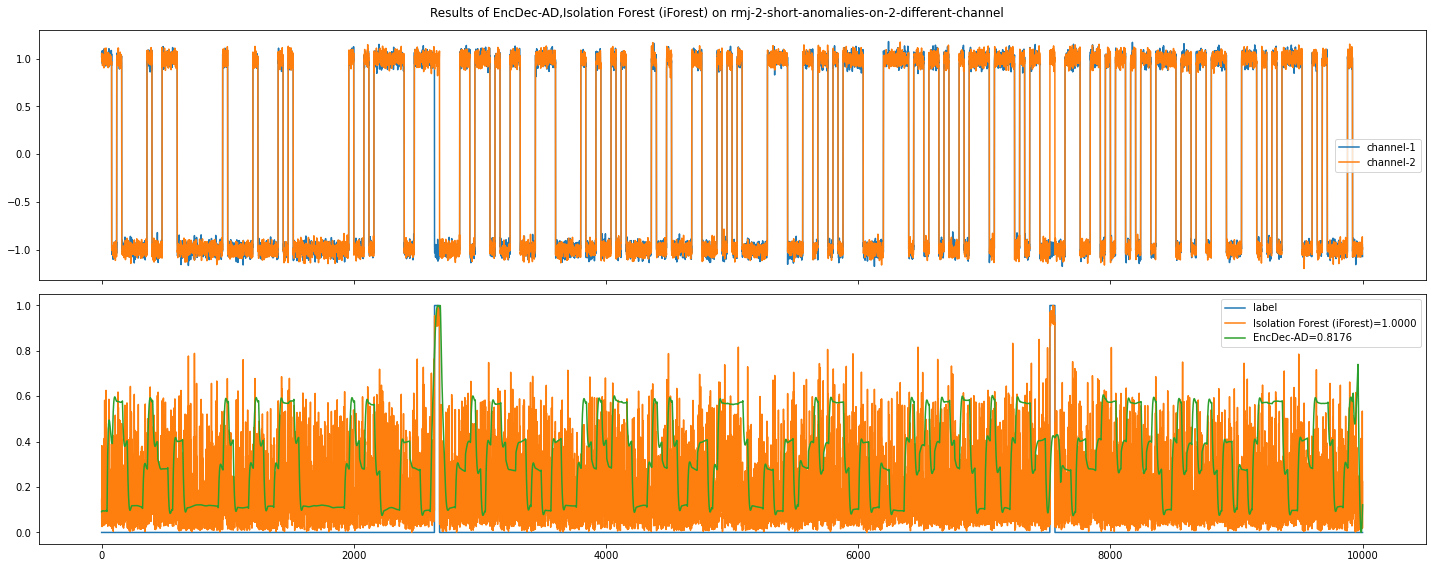

In [57]:
fig = plot_scores(["Isolation Forest (iForest)", "EncDec-AD"], "rmj-2-short-anomalies-on-2-different-channel")

### Best algorithms for different anomaly lengths

Find dataset names:

In [58]:
dataset_names = df_asl.index
def get_dataset_names_by_length(length):
    return dataset_names[dataset_names.str.contains(length)]

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


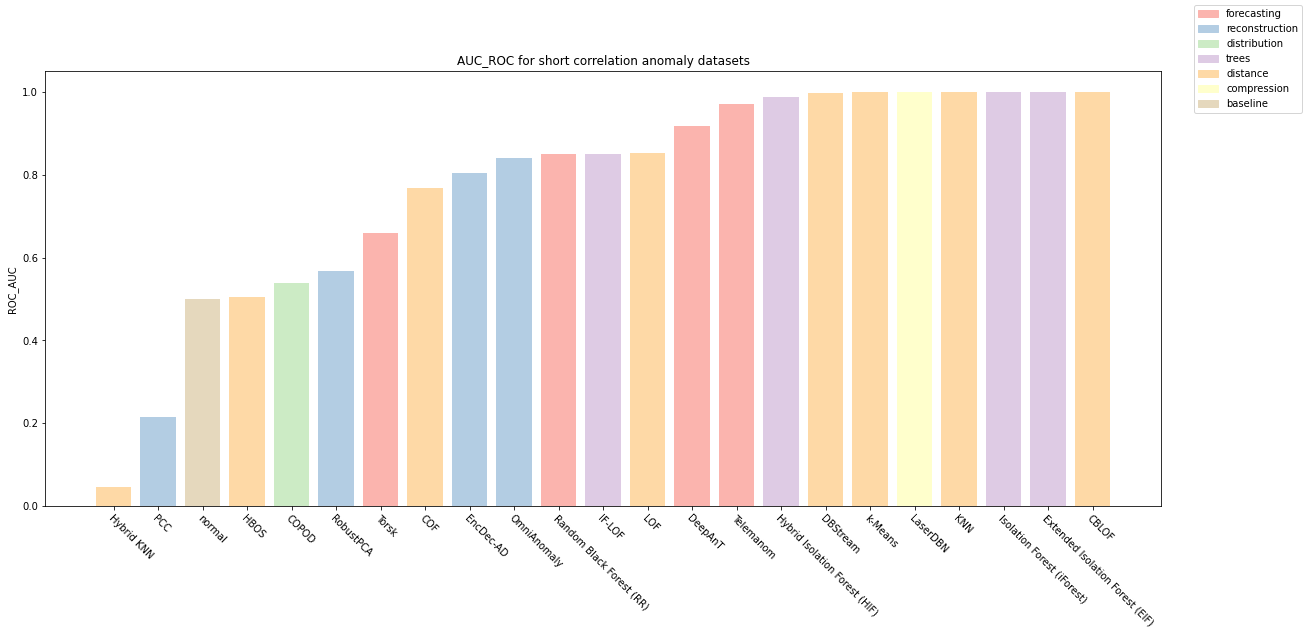

In [59]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_length("short")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for short correlation anomaly datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


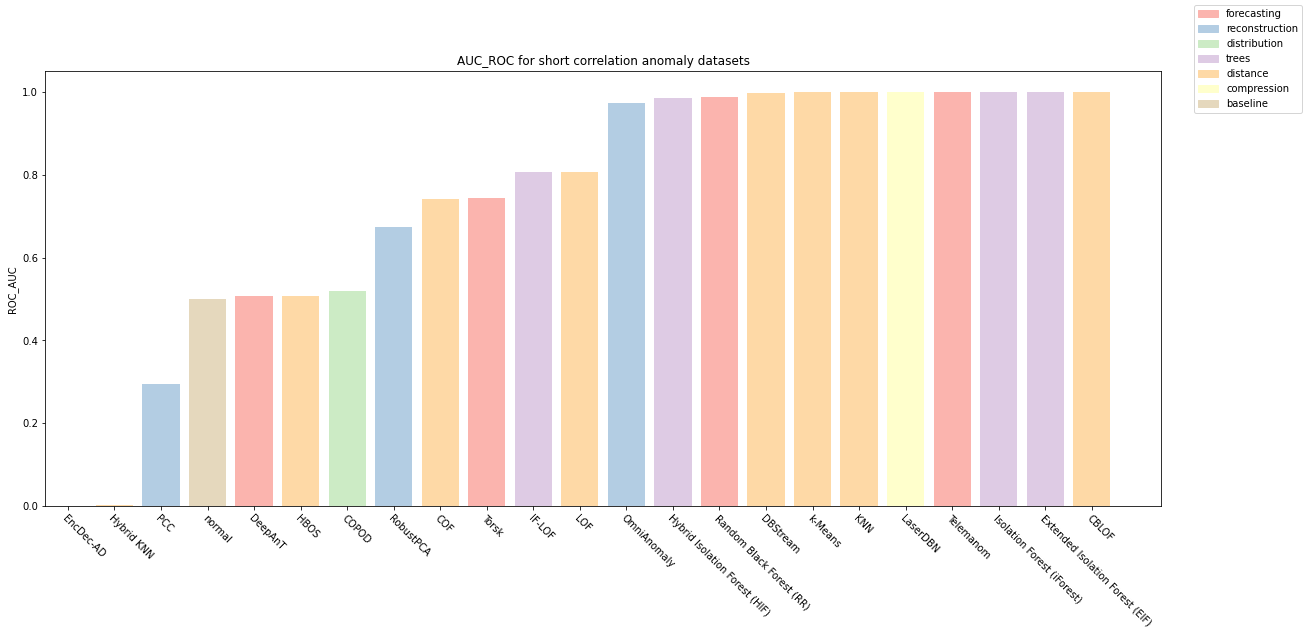

In [74]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_length("medium")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for medium correlation anomaly datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()

/tmp/ipykernel_12358/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


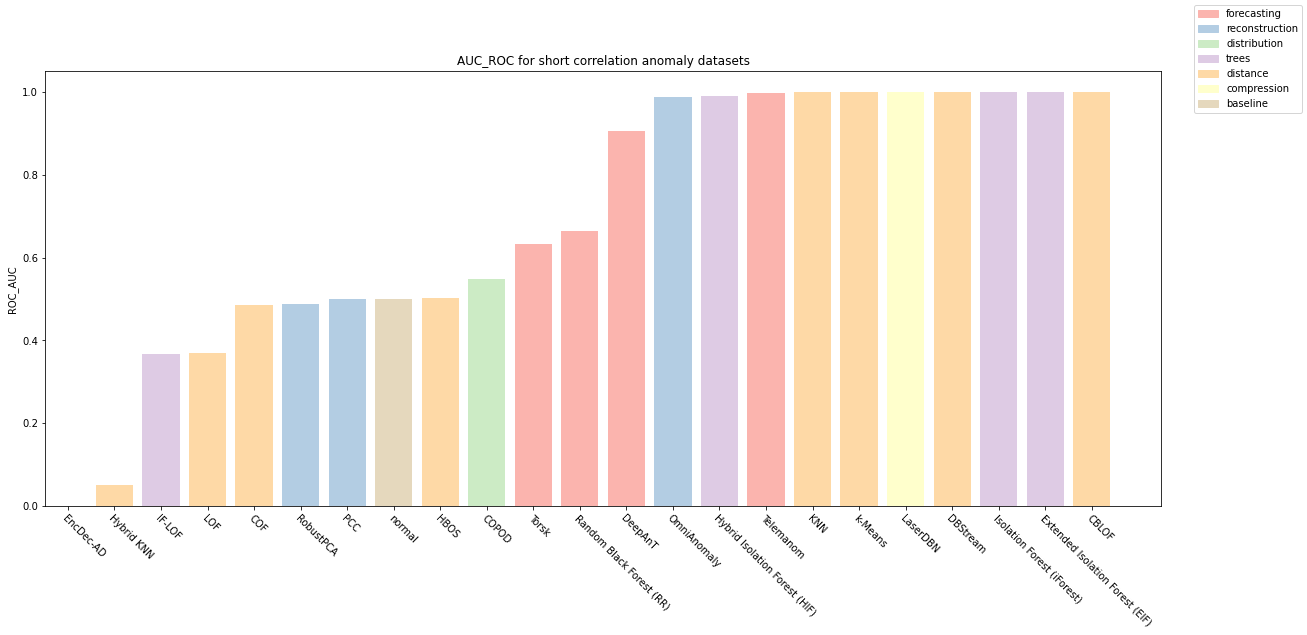

In [75]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_length("large")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for large correlation anomaly datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)
plt.show()